# Preliminary data preprocessing and labelling
The index of the `raw_data` DataFrame should be a `datetime` index in order to work with the `form_pockets` method.

In [1]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from util import backrest
import talib
import pandas_ta as ta
import datetime
import mplfinance as mpf
import pickle
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from util import resticator
from hurst import compute_Hc

%matplotlib inline

#### SymbolDataPreprocess Class
This class handles the downloading, automatic labelling and pocket formation. The autolabeller simply classifies signals based on whether the price went up by 5% or not after the signal was generated. However, we may find improvements in implementing De Prado's metalabelling.

In [6]:
class SymbolDataPreprocess():
    def __init__(self, symbol, window, interval):
        self.symbol = symbol
        self.window = window
        self.interval = interval
        
    def download_data(self):
        ## Get data
        raw_data = backrest.primary_data(self.symbol, self.window, self.interval, False)
        data = raw_data.copy()
    
        return raw_data, data
    
    def download_scndry_data(self, window, interval, tf, tt):
        ## Get data
        raw_data = backrest.primary_data(self.symbol, window, interval, False, time_from = tf, time_to = tt)
        data = raw_data.copy()
        
        return raw_data
    
    def string_from_time(self, dt):
        return dt.strftime("%d") + " " + dt.strftime("%b") + ", " + dt.strftime("%Y") + ", " + dt.strftime("%H:%M:%S")
    
    def form_pockets(self, raw_data_no_ix, labelled_data, pocket_tf = "5m", window_length = 200):
        pocket_tf_time = int(''.join(filter(str.isdigit, pocket_tf)))
        pocket_tf_interval = str(''.join(filter(str.isalpha, pocket_tf)))
        
        pockets = []
        empt_ix = []
        for i, row in labelled_data.iterrows():    
            if pocket_tf_interval == "m":
                time_diff = datetime.timedelta(minutes = window_length*pocket_tf_time)
            elif pocket_tf_interval == "H":
                time_diff = datetime.timedelta(hours = window_length*pocket_tf_time)
                
            time_from = row["Time"] - time_diff
            time_to = row["Time"]

            time_from_str = self.string_from_time(time_from)
            time_to_str = self.string_from_time(time_to)

            segmented_data = self.download_scndry_data(window_length, pocket_tf, time_from_str, time_to_str)

            ## check if there are any empty dataframes and get the signal index to drop later
            if segmented_data.empty:
                empt_ix.append(i)
                continue
            else:
                pockets.append(segmented_data)
            
        return empt_ix, pockets # pockets is a list of dataframes
    
    @staticmethod
    def get_labelled_data(raw_data, data, col_to_check, pct_deviation, bars_to_check):        
        short_ema = talib.EMA(data['Volume'].values, 5)
        long_ema = talib.EMA(data['Volume'].values, 10)
        vol_osc = 100*(short_ema - long_ema) / long_ema

        data['rsi'] = raw_data.copy().ta.rsi()
        data['cmo'] = raw_data.copy().ta.cmo()
        data['vosc'] = vol_osc
        data['pct_change'] = (raw_data['Close'] - raw_data['Open'])/raw_data['Open']

        prev_prices = [0]
        unfiltered_signals_ix = []
        for i, row in data.iterrows():
            if row['vosc'] >= 40 and row['pct_change'] >=  0.05 and row['Close'] >= max(prev_prices[-10 :-1]) and row['rsi'] > 72:
                    unfiltered_signals_ix.append(i)
            prev_prices.append(row['Close'])
            
        filtered_signals_ix = []
        for time_ix in unfiltered_signals_ix:
            for j in range(1, bars_to_check):
                forward_ix = time_ix + datetime.timedelta(hours = j)
                if data.loc[forward_ix, col_to_check] >= data.loc[time_ix, "Close"]*(1+pct_deviation):
                    filtered_signals_ix.append([time_ix, 1])
                    ## change logic here: use triple barrier method instead?
                    break
                else:
                    filtered_signals_ix.append([time_ix, 0])
                    break

        filtered_signals_ix_df = pd.DataFrame(filtered_signals_ix, columns=["Time", "Signal"])

        return filtered_signals_ix_df
    
    @staticmethod
    def perform_tsa(pocket):
        pass

#### Preprocess all symbol data
Run through each USDT symbol on the list and create a `SymbolDataPreprocess` instance for each symbol. Create the labelled data and Candle Pockets for each of these signals. 

In [7]:
import random

with open ('symbollist', 'rb') as fp:
    symbols = pickle.load(fp)

symbols = ["CTXCUSDT", "ANTUSDT", "COCOSUSDT", "IOTXUSDT", "ANTUSDT", "PNTUSDT", \
           "GTOUSDT", "PERLUSDT", "DENTUSDT", "CHRUSDT", "CKBUSDT", "POWRUSDT", \
           "ELFUSDT", "ARDRUSDT", "POLYUSDT", "CHESSUSDT", "GTCUSDT", "STPTUSDT", \
           "PONDUSDT"]

print(symbols)

def generate_data_pockets(symbols, pocket_tf="1m", window_length=200):
    ix = 1
    sym_ix = 0
    labelled_datas = []
    empty_ixs = []
    data_pocket_list = [] # data pocket list for indicators
    rtrns_data = []
    prices_data = []
    signal_summaries = []
    for i, symbol in tqdm(enumerate(symbols)):
        try:
            sdp = SymbolDataPreprocess(symbol, 800, "1H")
            raw_data, data = sdp.download_data() # data here has datetime index
            labelled_data = sdp.get_labelled_data(raw_data, data, "High", 0.05, 10) #1m, 20
            empty_ix, data_pockets = sdp.form_pockets(raw_data, labelled_data, pocket_tf = pocket_tf, window_length=window_length) # hyperparams here
        except (KeyError, IndexError) as e:
            print(f"Error occurred, skipping symbol {symbol}...")
            continue
            
        if len(data_pockets) == 0:
            print(f"No data for {symbol}, skipping...")
            continue

        empty_ixs.append(empty_ix)
        data_pocket_list.append(data_pockets)
        labelled_datas.append(labelled_data)
            
        pocket_rows_rtrns = []
        pocket_rows_prices = []
        # assign an id and differentiate returns
        for pocket, time in zip(data_pockets, labelled_data["Time"].values): # iterate through the pockets for this particular symbol of the parent loop
            pocket_rtrns = pocket.copy()
            pocket_clean_df = pocket.copy()
            price = pocket_clean_df["Close"].iloc[-1]

            for typ in ["Open", "High", "Low", "Close", "Volume"]:
                pocket_clean_df[typ] = np.log(pocket_clean_df[typ]) - np.log(pocket_clean_df[typ].shift(1))

            pocket_clean_df = pocket_clean_df.iloc[1:]

            pocket_clean_df["id"] = [ix for i in range(len(pocket_clean_df))] # id for tsfresh - each data pocket (regardless of symbol) has a new id
            pocket_rows_rtrns.append(pocket_clean_df)

            ## prices dataframe
            pocket["id"] = [ix for i in range(len(pocket))] # id for tsfresh - each data pocket (regardless of symbol) has a new id
            pocket_rows_prices.append(pocket)
            
            signal_summary = [ix, time, symbol, price]
            signal_summaries.append(signal_summary)

            ix+=1

        pocket_rows_rtrns = pd.concat(pocket_rows_rtrns, axis=0)
        pocket_rows_prices = pd.concat(pocket_rows_prices, axis=0)

        rtrns_data.append(pocket_rows_rtrns)
        prices_data.append(pocket_rows_prices)

        sym_ix += 1

    ## check for empty pocket dataframes (if data couldn't be downloaded), and drop them if they exist
    y_to_drop = []

    prices_data = pd.concat(prices_data, axis=0)
    rtrns_data = pd.concat(rtrns_data, axis=0)
    print("Rows to drop:", empty_ixs)
    
    return labelled_datas, data_pocket_list, prices_data, rtrns_data, empty_ixs, signal_summaries

['CTXCUSDT', 'ANTUSDT', 'COCOSUSDT', 'IOTXUSDT', 'ANTUSDT', 'PNTUSDT', 'GTOUSDT', 'PERLUSDT', 'DENTUSDT', 'CHRUSDT', 'CKBUSDT', 'POWRUSDT', 'ELFUSDT', 'ARDRUSDT', 'POLYUSDT', 'CHESSUSDT', 'GTCUSDT', 'STPTUSDT', 'PONDUSDT']


In [8]:
labelled_datas, data_pocket_list, prices_data, rtrns_data, y_to_drop, sig_sum = generate_data_pockets(symbols, pocket_tf="5m")

18it [00:14,  2.14it/s]

Error occurred, skipping symbol STPTUSDT...


19it [00:14,  1.30it/s]

Rows to drop: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [9]:
labelled_datas_1h, data_pocket_list_1h, prices_data_1h, rtrns_data_1h, y_to_drop_1h, sig_sum_1h = generate_data_pockets(symbols, pocket_tf="1H")

18it [00:13,  2.21it/s]

Error occurred, skipping symbol STPTUSDT...


19it [00:13,  1.36it/s]

Rows to drop: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


#### Data cleaning
1. Impute the data to handle null values.
2. Get log returns, for tsfresh.
3. Fill any bad data with 0 for XGBoost.

In [10]:
def clean_data(prices_data, rtrns_data):  
    ## prices dataframe ------------------------------------------------------------------------------
    prices_clean_df = prices_data.copy()

    ## Final preprocessing before tsfresh
    prices_clean_df = prices_clean_df.reset_index()#.rename(columns={"index": "time"})
    prices_clean_df.drop("Time", axis=1, inplace=True)

    # fix null values
    prices_clean_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    prices_clean_df.fillna(0, inplace=True)

    # reset index
    prices_clean_df = prices_clean_df.reset_index().rename(columns={"index": "time"})


    ## returns dataframe -----------------------------------------------------------------------------
    rtrns_clean_df = rtrns_data.copy()

    ## Final preprocessing before tsfresh
    rtrns_clean_df = rtrns_clean_df.reset_index()#.rename(columns={"index": "time"})
    rtrns_clean_df.drop("Time", axis=1, inplace=True)

    # fix null values
    rtrns_clean_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    rtrns_clean_df.fillna(0, inplace=True)

    # reset index
    rtrns_clean_df = rtrns_clean_df.reset_index().rename(columns={"index": "time"})

    return prices_clean_df, rtrns_clean_df

In [11]:
prices_clean_df, rtrns_clean_df = clean_data(prices_data, rtrns_data)

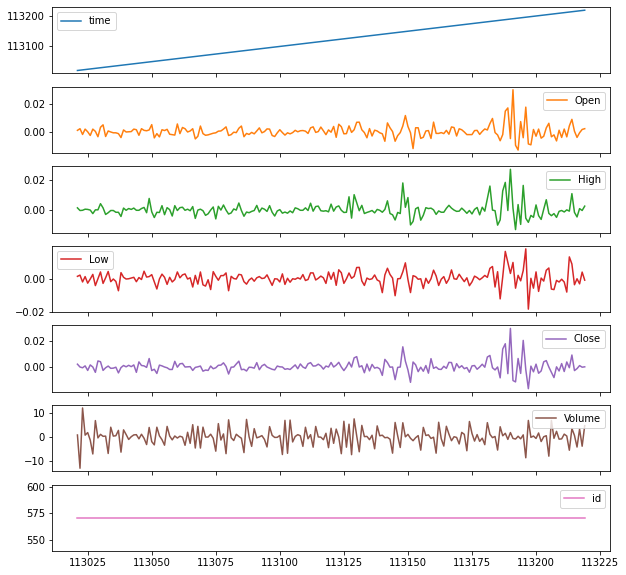

,time,Open,High,Low,Close,Volume,id
113021,113021,0.001035,0.001622,0.001478,0.002213,0.819547,571
113022,113022,0.002213,-0.000147,0.002213,0.000000,-12.862685,571
113023,113023,-0.001918,0.000000,-0.001918,-0.000590,11.939936,571
113024,113024,0.001918,0.000737,0.001328,0.000884,0.753010,571
113025,113025,0.000000,0.000589,-0.002658,-0.002656,1.813804,571
...,...,...,...,...,...,...,...
113215,113215,0.000417,-0.001387,-0.003619,-0.002781,0.645841,571
113216,113216,-0.004035,-0.004452,0.000000,-0.001254,-4.140444,571
113217,113217,-0.000697,0.001115,-0.003072,0.001115,3.247583,571
113218,113218,0.001673,-0.000139,0.004048,-0.000139,-3.797179,571


In [12]:
rtrns_clean_df[rtrns_clean_df['id']==571].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()
rtrns_clean_df[rtrns_clean_df['id']==571]

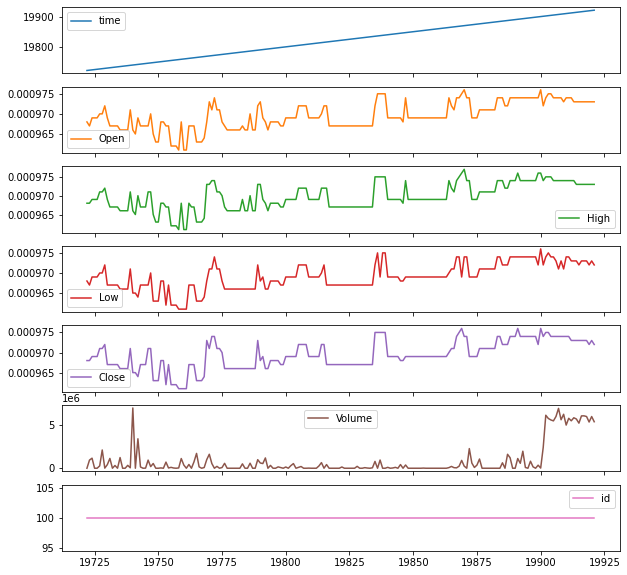

,time,Open,High,Low,Close,Volume,id
19722,19722,0.000968,0.000968,0.000968,0.000968,0.0,100
19723,19723,0.000967,0.000968,0.000967,0.000968,937558.0,100
19724,19724,0.000969,0.000969,0.000969,0.000969,1159064.0,100
19725,19725,0.000969,0.000969,0.000969,0.000969,0.0,100
19726,19726,0.000969,0.000969,0.000969,0.000969,0.0,100
...,...,...,...,...,...,...,...
19917,19917,0.000973,0.000973,0.000973,0.000973,6037179.0,100
19918,19918,0.000973,0.000973,0.000973,0.000973,5958501.0,100
19919,19919,0.000973,0.000973,0.000972,0.000972,5325409.0,100
19920,19920,0.000973,0.000973,0.000973,0.000973,5955883.0,100


In [13]:
prices_clean_df[prices_clean_df['id']==100].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()
prices_clean_df[prices_clean_df['id']==100]

In [14]:
prices_clean_1h_df, rtrns_clean_1h_df = clean_data(prices_data_1h, rtrns_data_1h)

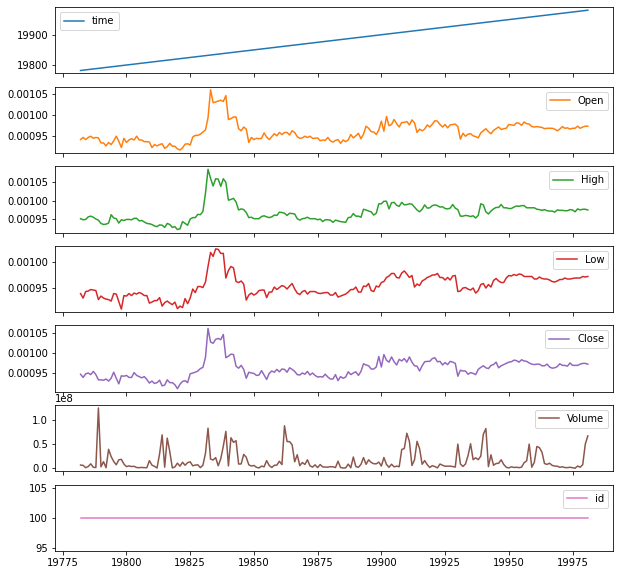

,time,Open,High,Low,Close,Volume,id
0,0,0.06770,0.06820,0.06730,0.06820,6512.59,1
1,1,0.06770,0.06770,0.06770,0.06770,42.35,1
2,2,0.06680,0.06680,0.06660,0.06680,3663.31,1
3,3,0.06680,0.06680,0.06680,0.06680,0.00,1
4,4,0.06680,0.06680,0.06680,0.06680,0.00,1
...,...,...,...,...,...,...,...
113435,113435,0.06926,0.06926,0.06926,0.06926,1531.80,571
113436,113436,0.06940,0.07083,0.06884,0.07027,5156811.75,571
113437,113437,0.07027,0.07400,0.06926,0.07362,30902959.17,571
113438,113438,0.07347,0.07357,0.07134,0.07137,6510221.41,571


In [15]:
prices_clean_1h_df[prices_clean_1h_df['id']==100].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()
prices_clean_1h_df

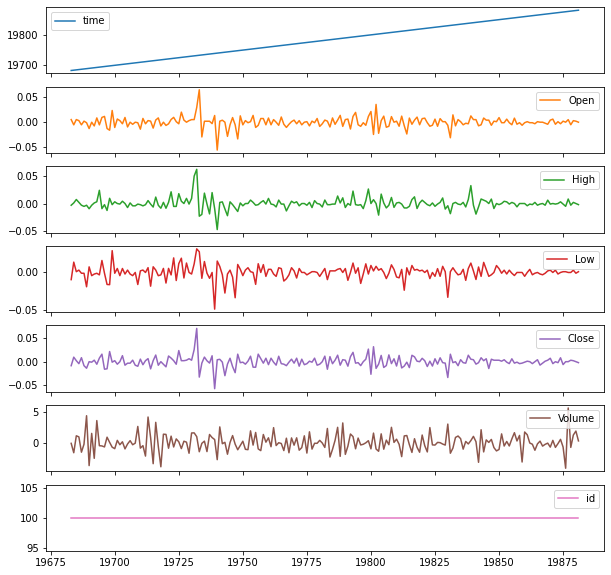

,time,Open,High,Low,Close,Volume,id
0,0,0.000000,-0.007358,0.005926,-0.007358,-5.035524,1
1,1,-0.013383,-0.013383,-0.016382,-0.013383,4.460154,1
2,2,0.000000,0.000000,0.002999,0.000000,0.000000,1
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,4,0.002990,0.007457,0.002990,0.007457,0.000000,1
...,...,...,...,...,...,...,...
112864,112864,0.003471,-0.021144,0.008118,0.000144,-8.563456,571
112865,112865,0.002019,0.022415,-0.006083,0.014477,8.121630,571
112866,112866,0.012458,0.043782,0.006083,0.046572,1.790533,571
112867,112867,0.044532,-0.005828,0.029590,-0.031039,-1.557478,571


In [16]:
rtrns_clean_1h_df[rtrns_clean_1h_df['id']==100].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()
rtrns_clean_1h_df

#### More cleaning
Make sure that the dataset is clean by ensuring that the returned array `ix` is empty.

In [17]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_remove = df.isin([np.nan, np.inf, -np.inf]).any(1)
    ix = indices_to_remove[indices_to_remove==True].index.values
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return ix, df[indices_to_keep].astype(np.float64)

ix, clean_data = clean_dataset(rtrns_clean_df)
ix

array([], dtype=int64)

In [18]:
for i, rtd in enumerate(y_to_drop):
    labelled_datas[i].drop(rtd, axis='index', inplace=True)
    
y = pd.concat(labelled_datas, axis='index')
y = y.reset_index()
y = y.reset_index()
y.index+=1
y = y["Signal"]
y

1      0
2      0
3      0
4      0
5      0
      ..
567    1
568    0
569    0
570    1
571    0
Name: Signal, Length: 571, dtype: int64

In [19]:
len(y)

571

In [20]:
rtrns_clean_df

,time,Open,High,Low,Close,Volume,id
0,0,0.001455,0.001455,0.001455,0.001455,0.698191,1
1,1,0.000000,0.000000,0.000000,0.000000,1.029989,1
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,3,0.000000,0.004351,-0.004370,0.004351,0.000000,1
4,4,0.004351,0.000000,0.008721,0.000000,2.278940,1
...,...,...,...,...,...,...,...
113215,113215,0.000417,-0.001387,-0.003619,-0.002781,0.645841,571
113216,113216,-0.004035,-0.004452,0.000000,-0.001254,-4.140444,571
113217,113217,-0.000697,0.001115,-0.003072,0.001115,3.247583,571
113218,113218,0.001673,-0.000139,0.004048,-0.000139,-3.797179,571


# Feature Engineering
## TSFresh Feature Engineering
#### Initial feature extraction

In [21]:
from tsfresh import extract_features

extracted_features = extract_features(rtrns_clean_df, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 30/30 [01:23<00:00,  2.78s/it]


In [22]:
extracted_features

,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,Open__median,...,Volume__permutation_entropy__dimension_5__tau_1,Volume__permutation_entropy__dimension_6__tau_1,Volume__permutation_entropy__dimension_7__tau_1,Volume__query_similarity_count__query_None__threshold_0.0,"Volume__matrix_profile__feature_""min""__threshold_0.98","Volume__matrix_profile__feature_""max""__threshold_0.98","Volume__matrix_profile__feature_""mean""__threshold_0.98","Volume__matrix_profile__feature_""median""__threshold_0.98","Volume__matrix_profile__feature_""25""__threshold_0.98","Volume__matrix_profile__feature_""75""__threshold_0.98"
1,0.0,0.0,0.0,1.0,0.023023,0.001204,0.001865,0.000021,0.000018,0.000000,...,1.041692,1.235501,1.409506,NaN,1.455185,9.203708,5.377901,5.068299,4.577657,6.928893
2,0.0,0.0,0.0,1.0,0.015121,0.001775,0.002705,0.000007,0.000014,0.000000,...,1.625091,1.964553,2.236924,NaN,2.861538,7.745967,4.558747,4.180059,4.000920,4.846899
3,0.0,0.0,0.0,1.0,0.075778,0.007064,0.005664,-0.000050,-0.000043,0.000000,...,4.039355,4.665787,4.961820,NaN,0.862738,2.990955,2.063921,2.171119,1.741376,2.393435
4,0.0,0.0,0.0,1.0,0.096379,0.009609,0.005903,-0.000071,-0.000010,0.000000,...,2.401809,2.944597,3.476927,NaN,1.413122,6.000000,2.709388,2.631605,2.069586,3.113929
5,0.0,0.0,0.0,1.0,0.038540,0.002935,0.003114,0.000040,-0.000045,0.000000,...,1.253899,1.465816,1.640026,NaN,1.951154,9.591663,4.977124,3.525505,2.899967,7.306466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,0.0,0.0,0.0,1.0,0.074473,0.005848,0.004871,-0.000107,-0.000098,0.000107,...,4.400479,5.093661,5.248324,NaN,NaN,NaN,NaN,NaN,NaN,NaN
568,0.0,0.0,0.0,1.0,0.021047,0.002121,0.003262,0.000001,-0.000017,0.000000,...,4.330775,5.059683,5.219593,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569,0.0,0.0,0.0,1.0,0.102302,0.010716,0.007099,-0.000056,-0.000022,0.000000,...,4.448320,5.065883,5.233959,NaN,1.180213,2.905452,1.953636,1.968959,1.684888,2.153186
570,0.0,0.0,0.0,1.0,0.033307,0.007134,0.005591,0.000141,-0.000013,-0.000214,...,4.333689,5.033797,5.226776,NaN,1.132855,2.658418,1.880981,1.878912,1.610775,2.163393


In [23]:
len(extracted_features)

571

In [24]:
## feature selection
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
features_filtered = select_features(extracted_features, y, fdr_level=0.5)

Get only relevant features

In [25]:
features_filtered

,"Close__fft_coefficient__attr_""abs""__coeff_8","Open__fft_coefficient__attr_""abs""__coeff_8","Close__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2",Open__time_reversal_asymmetry_statistic__lag_2,"Low__fft_coefficient__attr_""abs""__coeff_8","Close__fft_coefficient__attr_""abs""__coeff_77","High__fft_coefficient__attr_""abs""__coeff_8","Open__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","Close__fft_coefficient__attr_""abs""__coeff_9","Close__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""",...,"High__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.6","Close__fft_coefficient__attr_""real""__coeff_52","Close__fft_coefficient__attr_""imag""__coeff_44","Low__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8","Open__fft_coefficient__attr_""abs""__coeff_52","Close__fft_coefficient__attr_""abs""__coeff_48","Open__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","Close__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","Low__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","High__fft_coefficient__attr_""real""__coeff_12"
1,0.025173,0.019282,0.000017,1.120082e-10,0.018433,0.015561,0.020456,0.000015,0.033452,0.000016,...,0.000158,0.005899,0.012583,0.000006,0.036713,0.008869,1.685718e-05,0.000000e+00,0.000000e+00,-0.025983
2,0.027645,0.024743,-0.000128,-1.655072e-09,0.029262,0.063929,0.026581,0.000019,0.016536,0.000018,...,-0.000028,-0.001492,0.014148,0.000005,0.048382,0.015610,1.502540e-05,0.000000e+00,0.000000e+00,-0.003417
3,0.097952,0.097848,0.000003,1.489567e-07,0.099890,0.079549,0.105300,0.000061,0.050563,0.000078,...,0.001123,0.087876,-0.097457,0.000018,0.069304,0.081542,9.787996e-07,2.366861e-06,0.000000e+00,-0.073671
4,0.079002,0.073262,-0.000059,1.805896e-07,0.068182,0.218195,0.081098,0.000067,0.054259,0.000071,...,0.000228,0.077961,0.101062,0.000170,0.112093,0.033402,-2.392031e-05,1.794885e-07,0.000000e+00,0.009567
5,0.011948,0.012573,0.000051,2.452577e-08,0.005004,0.038104,0.026740,0.000035,0.066697,0.000035,...,0.000270,-0.005176,0.052388,0.000010,0.029056,0.009600,8.456963e-06,0.000000e+00,0.000000e+00,0.028906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,0.054252,0.053628,0.000356,4.513117e-08,0.038030,0.099610,0.062078,0.000053,0.024424,0.000051,...,-0.000485,0.034048,-0.014728,0.000045,0.061865,0.063970,5.326309e-05,1.408049e-06,3.052289e-08,-0.092652
568,0.063140,0.063244,0.000369,4.557885e-09,0.062615,0.051681,0.069387,0.000030,0.030721,0.000037,...,-0.000189,0.048909,-0.048249,0.000025,0.051091,0.011309,5.584749e-06,7.227324e-07,7.628517e-09,0.018980
569,0.069970,0.085123,0.000478,8.217633e-09,0.052260,0.129587,0.093118,0.000104,0.130834,0.000093,...,0.001289,0.042064,0.010663,0.000055,0.092334,0.125321,-1.905834e-05,5.406795e-06,1.376495e-07,0.063427
570,0.034097,0.075156,0.000434,-3.480053e-08,0.063712,0.081296,0.039088,0.000063,0.063256,0.000059,...,0.001596,-0.008159,0.014034,0.000025,0.012770,0.032511,3.257446e-05,2.282639e-06,5.555792e-08,0.065583


In [26]:
len(features_filtered)

571

In [27]:
len(y)

571

Check if the lengths match

In [28]:
if len(features_filtered) == len(y):
    print("The lengths match!")
else:
    print("Problem :(")

The lengths match!


## Indicators
Here, I added some traditional market indicators to see if they would have any relevance. For fun, I included candle patterns, although I don't think this has any predictive power.

### Candle Patterns

In [29]:
def get_candle_patterns(data):
    candle_data = data.copy().ta.cdl_pattern(name="all")
    candle_data.loc['total'] = candle_data.sum(axis=0)
    candle_data = candle_data.loc['total']
    columns = candle_data.index.values
    
    ptns = []
    for ptn in candle_data:
        if ptn != 0:
            ptns.append(1)
        else:
            ptns.append(0)
    return ptns, columns

#get_candle_patterns(data)

ptns = []
for x in tqdm(data_pocket_list):
    for z in x:
        ptn, col = get_candle_patterns(z)
        ptns.append(ptn)

pattern_df = pd.DataFrame(ptns, columns = col)
pattern_df.index += 1
pattern_df

100%|██████████| 18/18 [00:08<00:00,  2.03it/s]


,CDL_2CROWS,CDL_3BLACKCROWS,CDL_3INSIDE,CDL_3LINESTRIKE,CDL_3OUTSIDE,CDL_3STARSINSOUTH,CDL_3WHITESOLDIERS,CDL_ABANDONEDBABY,CDL_ADVANCEBLOCK,CDL_BELTHOLD,...,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,1,0,0,0,1,1,...,1,1,0,1,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
5,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,1,0,1,0,1,0,0,0,0,1,...,1,0,0,1,0,1,0,1,0,1
568,0,1,1,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1
569,0,0,0,1,1,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,1
570,0,0,1,0,1,0,0,0,1,1,...,1,0,0,1,0,1,0,0,0,1


In [30]:
## join with existing features df
features_filtered = features_filtered.join(pattern_df)
features_filtered

,"Close__fft_coefficient__attr_""abs""__coeff_8","Open__fft_coefficient__attr_""abs""__coeff_8","Close__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2",Open__time_reversal_asymmetry_statistic__lag_2,"Low__fft_coefficient__attr_""abs""__coeff_8","Close__fft_coefficient__attr_""abs""__coeff_77","High__fft_coefficient__attr_""abs""__coeff_8","Open__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","Close__fft_coefficient__attr_""abs""__coeff_9","Close__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""",...,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS
1,0.025173,0.019282,0.000017,1.120082e-10,0.018433,0.015561,0.020456,0.000015,0.033452,0.000016,...,0,0,0,0,0,0,0,0,0,0
2,0.027645,0.024743,-0.000128,-1.655072e-09,0.029262,0.063929,0.026581,0.000019,0.016536,0.000018,...,0,0,0,0,0,0,1,0,0,0
3,0.097952,0.097848,0.000003,1.489567e-07,0.099890,0.079549,0.105300,0.000061,0.050563,0.000078,...,1,1,0,1,0,1,0,0,0,0
4,0.079002,0.073262,-0.000059,1.805896e-07,0.068182,0.218195,0.081098,0.000067,0.054259,0.000071,...,0,0,0,1,0,0,1,0,0,0
5,0.011948,0.012573,0.000051,2.452577e-08,0.005004,0.038104,0.026740,0.000035,0.066697,0.000035,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,0.054252,0.053628,0.000356,4.513117e-08,0.038030,0.099610,0.062078,0.000053,0.024424,0.000051,...,1,0,0,1,0,1,0,1,0,1
568,0.063140,0.063244,0.000369,4.557885e-09,0.062615,0.051681,0.069387,0.000030,0.030721,0.000037,...,1,0,0,1,0,0,0,0,0,1
569,0.069970,0.085123,0.000478,8.217633e-09,0.052260,0.129587,0.093118,0.000104,0.130834,0.000093,...,0,0,0,1,0,0,0,0,0,1
570,0.034097,0.075156,0.000434,-3.480053e-08,0.063712,0.081296,0.039088,0.000063,0.063256,0.000059,...,1,0,0,1,0,1,0,0,0,1


### Indicators
Problem here - a lot of RuntimeWarnings where `pandas` is dividing by zero or something similar. How do we handle for this?
#### Candle Pocket Indicators
Indicators calculated for each candle pocket. We also need to calculate the indicators for the actual main data.

In [27]:
def vosc(data):
    short_ema = talib.EMA(data['Volume'].values, 5)
    long_ema = talib.EMA(data['Volume'].values, 10)
    vol_osc = 100*(short_ema - long_ema) / long_ema
    
    return vol_osc

def get_indicators(data):
    raw_data = data.copy()
    # overlap indicators (need to add ichimoku)
    overlap_ind = "alma, dema, ema_200, ema_100, ema_25, ema_9, fwma, hilo, hl2, hlc3, hma, hwma, kama, linreg, mcgd, midpoint, midprice, ohlc4, pwma, rma, sinwma, sma, ssf, supertrend, swma, t3, tema, trima, vidya, vwap, vwma, wcp, wma, zlma"
    overlap_ind = overlap_ind.split(", ")

    for indi in overlap_ind:
        try:
            #print(indi[:3])
            if indi[:3] == "ema":
                ema_period = int(''.join(filter(str.isdigit, indi)))
                indicator_data = raw_data.copy().ta.ema(ema_period)
            else:
                indicator_data = getattr(raw_data.copy().ta, indi)()
            indicator_data = raw_data["Close"]/indicator_data - 1
            if isinstance(indicator_data, pd.DataFrame):
                data.join(indicator_data)
            elif isinstance(indicator_data, pd.Series):
                data[indi] = indicator_data
            else:
                pass
        except Exception as e:
            print(f"Exception occurred on {indi}:", e)
            pass
    
    # momentum indicators
    mom_ind = "ao, apo, bias, bop, brar, cci, cfo, cg, cmo, coppock, cti, dm, er, eri, fisher, inertia, kdj, kst, macd, mom, pgo, ppo, psl, pvo, qqe, roc, rsi, rsx, rvgi, stc, slope, smi, squeeze, squeeze_pro, stoch, stochrsi, td_seq, trix, tsi, uo, willr, ebsw"
    mom_ind = mom_ind.split(", ")

    for indi in mom_ind:
        try:
            indicator_data = getattr(raw_data.copy().ta, indi)()

            if indi == "coppock":
                indicator_data = indicator_data.pct_change()
                #indicator_data = np.log(indicator_data) - np.log(indicator_data.shift(1))
            else:
                pass

            if isinstance(indicator_data, pd.DataFrame):
                data.join(indicator_data)
            elif isinstance(indicator_data, pd.Series):
                data[indi] = indicator_data
            else:
                pass

        except Exception as e:
            print(f"Exception occurred on {indi}:", e)
            pass
        
    data["vosc"] = vosc(raw_data)
    data["lrsi"] = resticator.LRSI(data, 14)
    
    # statistical indicators
    stat_ind = "entropy, kurtosis, mad, median, quantile, skew, stdev, tos_stdevall, variance, zscore"
    stat_ind = stat_ind.split(", ")

    for indi in stat_ind:
        try:
            indicator_data = getattr(raw_data.copy().ta, indi)()
            if isinstance(indicator_data, pd.DataFrame):
                data.join(indicator_data)
            elif isinstance(indicator_data, pd.Series):
                data[indi] = indicator_data
            else:
                pass

        except Exception as e:
            print(f"Exception occurred on {indi}:", e)
            pass
    
    # trend indicators
    trend_ind = "adx, amat, aroon, chop, cksp, decay, decreasing, dpo, increasing, long_run, psar, qstick, short_run, tsignals, ttm_trend, vhf, vortex, xsignals"
    trend_ind = trend_ind.split(", ")

    for indi in trend_ind:
        try:        
            if indi == "dpo":
                indicator_data = raw_data.copy().ta.dpo(lookahead=False, centered=False)
            else:
                indicator_data = getattr(raw_data.copy().ta, indi)()

            if isinstance(indicator_data, pd.DataFrame):
                data.join(indicator_data)
            elif isinstance(indicator_data, pd.Series):
                data[indi] = indicator_data
            else:
                pass

        except Exception as e:
            print(f"Exception occurred on {indi}:", e)
            pass
    
    # volume indicators
    vol_ind = "ad, adosc, aobv, cmf, efi, kvo, mfi, nvi, obv, pvi, pvol, pvr, pvt"
    vol_ind = vol_ind.split(", ")

    for indi in vol_ind:
        try:
            indicator_data = getattr(raw_data.copy().ta, indi)()

            if indi == "aobv" or indi == "obv":
                indicator_data = indicator_data.pct_change()
                #indicator_data = np.log(indicator_data) - np.log(indicator_data.shift(1))

            if isinstance(indicator_data, pd.DataFrame):
                data.join(indicator_data)
            elif isinstance(indicator_data, pd.Series):
                data[indi] = indicator_data
            else:
                pass

        except Exception as e:
            print(f"Exception occurred on {indi}:", e)
            #print(indicator_data)
    
    # volatility indicators
    volatility_ind = "aberration, accbands, atr, bbands, donchian, hwc, kc, massi, natr, pdist, rvi, thermo, true_range, ui"
    volatility_ind = volatility_ind.split(", ")
    for indi in volatility_ind:
        try:
            indicator_data = getattr(raw_data.copy().ta, indi)()

            if indi == "aberration" or indi == "hwc" or indi == "bbands" or indi == "donchian" or indi == "kc" \
            or indi == "accbands":
                indicator_data = raw_data["Close"]/indicator_data - 1

            if indi == "atr" or indi == "natr" or indi == "thermo" or indi == "pdist" or indi == "true_range":
                indicator_data = indicator_data.pct_change()
                #indicator_data = np.log(indicator_data) - np.log(indicator_data.shift(1))

            if isinstance(indicator_data, pd.DataFrame):
                data.join(indicator_data)
            elif isinstance(indicator_data, pd.Series):
                data[indi] = indicator_data
            else:
                pass

        except Exception as e:
            print(f"Exception occurred on {indi}:", e)
            #print(indicator_data)
    
    # other
    ## Hurst Exponent - numerical (or categorical?)
    '''try:
        hurst_exp, hurst_type = resticator.HURST_EXP(data, 100)
        data["hurst_exp"] = hurst_exp
        data["hurst_type"] = hurst_type
    except FloatingPointError as e:
        print("Exception :(")
        print(e)'''
        
    hurst_exp = resticator.HURST_EXP(data, 20)
    hurst_type = 0 if 0 < hurst_exp < 0.5 else 1
    
    # price action
    n_green_candles = 0
    n_red_candles = 0
    for i, row in raw_data.iterrows():
        if row["Close"] >= row["Open"]:
            n_green_candles+=1
        else:
            n_red_candles+=1

    data = data.drop(["Open", "High", "Low", "Close", "Volume"], axis=1)
    data_last_row = data.iloc[-1].values
    data_last_row = np.append(data_last_row, [hurst_exp, hurst_type])
    #data_last_row = np.append(data_last_row, n_green_candles)
    #data_last_row = np.append(data_last_row, n_red_candles)
    df_columns = np.append(data.columns.values, ["hurst_exp", "hurst_type"])
            
    return data_last_row, df_columns

#get_candle_patterns(data)

In [28]:
import copy

dpl_copy = copy.deepcopy(data_pocket_list)
dpl_copy_1h = copy.deepcopy(data_pocket_list_1h)

Form dataframe for indicators

In [29]:
indis = []
for x in tqdm(dpl_copy):
    for z in x:
        if z.isnull().values.any():
            print("Error: DataFrame contains NaN value")
        z.drop("id", axis=1, inplace=True)
        indi, col = get_indicators(z)
        indis.append(indi)

indi_df = pd.DataFrame(indis, columns = col)
indi_df

100%|██████████| 18/18 [06:54<00:00, 23.00s/it]


,alma,dema,ema_200,ema_100,ema_25,ema_9,fwma,hl2,hlc3,hma,...,pvt,atr,massi,natr,pdist,rvi,true_range,ui,hurst_exp,hurst_type
0,0.005722,0.003938,0.022419,0.015007,0.005746,0.004366,0.003514,0.000000,0.000000,0.004329,...,-1.486933e+04,0.208663,15.855850,0.201786,9.007199e+11,67.815059,inf,0.955435,0.299678,0.0
1,0.003228,0.001251,0.019522,0.012656,0.003710,0.001623,0.001479,0.000682,0.000454,0.001636,...,2.249794e+04,-0.018456,33.218095,-0.021131,4.503600e+11,61.542861,inf,0.586990,0.225279,0.0
2,-0.020681,-0.011836,0.034297,0.016790,-0.001674,-0.009696,-0.007662,-0.000991,-0.000661,-0.007208,...,3.488183e+05,0.000674,28.513327,0.006630,-5.384615e-01,47.967763,-0.571429,1.153560,0.372433,0.0
3,-0.019454,0.003970,0.030462,0.000113,-0.009626,-0.002546,0.002096,0.000000,0.000000,0.012219,...,4.295034e+05,-0.071429,22.024635,-0.071429,-1.000000e+00,47.886954,-1.000000,1.831095,0.358683,0.0
4,-0.008986,-0.000984,0.025601,0.002783,-0.010693,-0.005730,-0.002163,0.000000,0.000000,-0.000839,...,2.723481e+05,-0.071429,21.463769,-0.071429,0.000000e+00,30.866866,NaN,1.964616,0.408166,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,0.013893,-0.004934,0.076691,0.063068,0.028393,0.007440,0.000087,0.002071,0.001380,-0.006801,...,1.627057e+07,0.005530,27.457848,0.002463,-4.556114e-01,73.302545,-0.556110,1.344028,0.417529,0.0
567,-0.001492,-0.001841,0.013711,0.010294,0.005604,0.001064,-0.000153,-0.000942,-0.000628,0.000855,...,3.886653e+06,-0.039974,26.255696,-0.038735,8.235294e-01,44.659090,0.357143,0.362060,0.387838,0.0
568,0.049690,0.012858,0.060001,0.047244,0.038607,0.024900,0.013914,0.009328,0.006199,0.008145,...,5.833753e+07,0.109308,28.189922,0.086154,9.758065e-01,64.246677,1.298969,0.705357,0.356521,0.0
569,0.044897,0.018967,0.063168,0.053594,0.042441,0.030012,0.018987,0.011758,0.007808,0.018932,...,1.081938e+07,0.165504,26.797448,0.137948,3.698630e-01,80.222055,0.848276,0.544495,0.210179,0.0


In [30]:
indis_1h = []
for x in tqdm(dpl_copy_1h):
    for z in x:
        try:
            z.drop("id", axis=1, inplace=True)
            indi, col = get_indicators(z)
            indis_1h.append(indi)
        except:
            print("Length:", len(z))
            print("Shape:", z.shape)
            print(z)

indi_1h_df_columns = col + "_1h"
indi_1h_df = pd.DataFrame(indis_1h, columns = indi_1h_df_columns)
indi_1h_df

 67%|██████▋   | 12/18 [05:39<01:48, 18.07s/it]

Exception occurred on smi: inputs are all NaN
Exception occurred on stochrsi: inputs are all NaN


100%|██████████| 18/18 [07:01<00:00, 23.41s/it]


,alma_1h,dema_1h,ema_200_1h,ema_100_1h,ema_25_1h,ema_9_1h,fwma_1h,hl2_1h,hlc3_1h,hma_1h,...,pvt_1h,atr_1h,massi_1h,natr_1h,pdist_1h,rvi_1h,true_range_1h,ui_1h,hurst_exp_1h,hurst_type_1h
0,0.028482,0.007969,0.040741,0.031000,0.019178,0.013969,0.007184,0.000000,0.000000,0.002555,...,9.162954e+05,-0.033633,24.418552,-0.039132,-0.826087,68.566666,-0.692308,1.507879,0.467341,0.0
1,0.024016,0.007092,0.036760,0.023218,0.017072,0.012595,0.006318,0.004791,0.003189,0.004358,...,1.120777e+05,0.089935,23.888011,0.089935,0.500000,78.298970,0.071429,0.949848,0.340589,0.0
2,0.025784,0.004585,0.176539,0.109096,0.042580,0.017919,0.009355,-0.018022,-0.012088,0.012968,...,3.217259e+06,0.043994,27.941065,0.039851,0.195122,60.049549,-0.078431,1.198276,0.349203,0.0
3,-0.002762,-0.024256,0.087070,0.111064,0.048575,0.000017,-0.010059,-0.002132,-0.001422,-0.017745,...,-7.547686e+06,0.052630,27.839936,0.075122,1.461538,60.431281,1.500000,1.357485,0.431710,0.0
4,0.029602,-0.010699,0.080231,0.036264,0.016833,0.003158,-0.007700,-0.009363,-0.006262,-0.023069,...,1.498906e+07,0.056029,25.668623,0.083977,-0.157895,64.213403,0.666667,2.765895,0.525222,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,0.090426,0.039736,0.107371,0.096623,0.077089,0.056742,0.036619,0.012960,0.008603,0.034711,...,8.403342e+08,0.247868,27.651980,0.193832,1.616162,77.181405,2.514286,2.384988,0.208197,0.0
567,0.009238,0.008581,0.034457,0.023626,0.015224,0.011264,0.008666,0.007048,0.004688,0.011948,...,2.467890e+09,0.032179,25.313792,0.016911,1.290780,60.995930,2.080000,1.308526,0.292027,0.0
568,0.021418,0.025962,0.062539,0.094714,0.065266,0.039015,0.030071,0.029561,0.019515,0.047576,...,3.133532e+08,0.097127,27.898363,0.043694,3.447853,46.628815,4.146552,2.307550,0.472064,0.0
569,0.059503,0.041047,0.072599,0.046271,0.044620,0.045532,0.035805,0.030985,0.020446,0.043248,...,8.767011e+08,0.110751,25.682154,0.041315,1.775000,44.519228,2.798817,7.456411,0.286371,0.0


In [31]:
import pickle

with open('indis_1h_df_run7_hurst', 'wb') as fp:
        pickle.dump(indi_1h_df, fp)
        
with open('indis_5m_df_run7_hurst', 'wb') as fp:
        pickle.dump(indi_df, fp)

In [31]:
with open ('indis_1h_df_run7_hurst', 'rb') as fp:
        indi_1h_df = pickle.load(fp)
        
with open ('indis_5m_df_run7_hurst', 'rb') as fp:
        indi_df = pickle.load(fp)

In [32]:
indi_df.index+=1
indi_1h_df.index+=1

In [33]:
indi_df

,alma,dema,ema_200,ema_100,ema_25,ema_9,fwma,hl2,hlc3,hma,...,pvt,atr,massi,natr,pdist,rvi,true_range,ui,hurst_exp,hurst_type
1,0.005722,0.003938,0.022419,0.015007,0.005746,0.004366,0.003514,0.000000,0.000000,0.004329,...,-1.486933e+04,0.208663,15.855850,0.201786,9.007199e+11,67.815059,inf,0.955435,0.299678,0.0
2,0.003228,0.001251,0.019522,0.012656,0.003710,0.001623,0.001479,0.000682,0.000454,0.001636,...,2.249794e+04,-0.018456,33.218095,-0.021131,4.503600e+11,61.542861,inf,0.586990,0.225279,0.0
3,-0.020681,-0.011836,0.034297,0.016790,-0.001674,-0.009696,-0.007662,-0.000991,-0.000661,-0.007208,...,3.488183e+05,0.000674,28.513327,0.006630,-5.384615e-01,47.967763,-0.571429,1.153560,0.372433,0.0
4,-0.019454,0.003970,0.030462,0.000113,-0.009626,-0.002546,0.002096,0.000000,0.000000,0.012219,...,4.295034e+05,-0.071429,22.024635,-0.071429,-1.000000e+00,47.886954,-1.000000,1.831095,0.358683,0.0
5,-0.008986,-0.000984,0.025601,0.002783,-0.010693,-0.005730,-0.002163,0.000000,0.000000,-0.000839,...,2.723481e+05,-0.071429,21.463769,-0.071429,0.000000e+00,30.866866,NaN,1.964616,0.408166,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,0.013893,-0.004934,0.076691,0.063068,0.028393,0.007440,0.000087,0.002071,0.001380,-0.006801,...,1.627057e+07,0.005530,27.457848,0.002463,-4.556114e-01,73.302545,-0.556110,1.344028,0.417529,0.0
568,-0.001492,-0.001841,0.013711,0.010294,0.005604,0.001064,-0.000153,-0.000942,-0.000628,0.000855,...,3.886653e+06,-0.039974,26.255696,-0.038735,8.235294e-01,44.659090,0.357143,0.362060,0.387838,0.0
569,0.049690,0.012858,0.060001,0.047244,0.038607,0.024900,0.013914,0.009328,0.006199,0.008145,...,5.833753e+07,0.109308,28.189922,0.086154,9.758065e-01,64.246677,1.298969,0.705357,0.356521,0.0
570,0.044897,0.018967,0.063168,0.053594,0.042441,0.030012,0.018987,0.011758,0.007808,0.018932,...,1.081938e+07,0.165504,26.797448,0.137948,3.698630e-01,80.222055,0.848276,0.544495,0.210179,0.0


Join with existing features df

In [34]:
features_filtered = features_filtered.join([indi_df, indi_1h_df])
features_filtered

,"Close__fft_coefficient__attr_""abs""__coeff_8","Open__fft_coefficient__attr_""abs""__coeff_8","Close__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2",Open__time_reversal_asymmetry_statistic__lag_2,"Low__fft_coefficient__attr_""abs""__coeff_8","Close__fft_coefficient__attr_""abs""__coeff_77","High__fft_coefficient__attr_""abs""__coeff_8","Open__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","Close__fft_coefficient__attr_""abs""__coeff_9","Close__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""",...,pvt_1h,atr_1h,massi_1h,natr_1h,pdist_1h,rvi_1h,true_range_1h,ui_1h,hurst_exp_1h,hurst_type_1h
1,0.025173,0.019282,0.000017,1.120082e-10,0.018433,0.015561,0.020456,0.000015,0.033452,0.000016,...,9.162954e+05,-0.033633,24.418552,-0.039132,-0.826087,68.566666,-0.692308,1.507879,0.467341,0.0
2,0.027645,0.024743,-0.000128,-1.655072e-09,0.029262,0.063929,0.026581,0.000019,0.016536,0.000018,...,1.120777e+05,0.089935,23.888011,0.089935,0.500000,78.298970,0.071429,0.949848,0.340589,0.0
3,0.097952,0.097848,0.000003,1.489567e-07,0.099890,0.079549,0.105300,0.000061,0.050563,0.000078,...,3.217259e+06,0.043994,27.941065,0.039851,0.195122,60.049549,-0.078431,1.198276,0.349203,0.0
4,0.079002,0.073262,-0.000059,1.805896e-07,0.068182,0.218195,0.081098,0.000067,0.054259,0.000071,...,-7.547686e+06,0.052630,27.839936,0.075122,1.461538,60.431281,1.500000,1.357485,0.431710,0.0
5,0.011948,0.012573,0.000051,2.452577e-08,0.005004,0.038104,0.026740,0.000035,0.066697,0.000035,...,1.498906e+07,0.056029,25.668623,0.083977,-0.157895,64.213403,0.666667,2.765895,0.525222,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,0.054252,0.053628,0.000356,4.513117e-08,0.038030,0.099610,0.062078,0.000053,0.024424,0.000051,...,8.403342e+08,0.247868,27.651980,0.193832,1.616162,77.181405,2.514286,2.384988,0.208197,0.0
568,0.063140,0.063244,0.000369,4.557885e-09,0.062615,0.051681,0.069387,0.000030,0.030721,0.000037,...,2.467890e+09,0.032179,25.313792,0.016911,1.290780,60.995930,2.080000,1.308526,0.292027,0.0
569,0.069970,0.085123,0.000478,8.217633e-09,0.052260,0.129587,0.093118,0.000104,0.130834,0.000093,...,3.133532e+08,0.097127,27.898363,0.043694,3.447853,46.628815,4.146552,2.307550,0.472064,0.0
570,0.034097,0.075156,0.000434,-3.480053e-08,0.063712,0.081296,0.039088,0.000063,0.063256,0.000059,...,8.767011e+08,0.110751,25.682154,0.041315,1.775000,44.519228,2.798817,7.456411,0.286371,0.0


Now we need to get the indicators for the higher time-frame. We can do this by using the data that we already have; i.e there is no need for candle pockets.

In [35]:
with open('features_filtered_run8', 'wb') as fp:
    pickle.dump(features_filtered, fp)

In [35]:
#with open ('features_filtered', 'rb') as fp:
#    features_filtered = pickle.load(fp)